# Lab 3: Training and testing

|  Information  |  Your reply  |
|-----------|:---------------------------------|
| **Group** | BML36 |
| **Name 1** | Thibault Douzon |
| **Name 2** | Rajavarman Rathivaman |


In this lab we deal with overfitting and generalisation. We illustrate how these occur by extending last week's lab which was implementing logistic regression using basis functions.

# Logistic regression with base functions

$\newcommand{\x}{\mathbf{x}}\newcommand{\w}{\mathbf{w}}\newcommand{\c}{\mathcal{C}}\newcommand{\feat}{\boldsymbol{\phi}}$

As we have seen last week, the logistic regression models the probability of a class label $\c$ given a datapoint $p(\c|\x)$ as:
$$p(\c|\x) = \sigma(\w^\top\x) = \frac{1}{1+e^{-\w^\top\x}}$$

In this lab, we shall use basis functions to make this model non-linear in $\x$, while still remaining linear in $\w$, by replacing $\x$ with a fixed, non-linear feature vector function $\feat = f(\x)$, so that $p(\c|\x)=\sigma(\w^\top\feat)$

## Data

We start by generating a dataset. As we have seen in the lecture, the central problem of machine learning is to devise algorithms that will generalise to previously unseen data, *i.e.*, that will correctly consider the distribution of the data-generating process into account, rather than merely the distribution of the training data. As you can imagine, this is more difficult for small training sets. The dataset in "data-2class-nonlin" is very similar to the data that we have used before but smaller and, therefore, harder to learn from.


In [2]:
# This code is given
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
import copy
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

maxexp=40 # Python floats cannot represent exp(maxexp) and larger

def sigma(a):
    if a>maxexp:
        return 1.
    if a<-maxexp:
        return 0.
    return 1./(1.+np.exp(-a))
def log1pe(a):
    if a<-maxexp:
        return 0.
    if a>maxexp:
        return a
    return np.log(1.+np.exp(a))
def logsigma(a):
    return -log1pe(-a)
#    return -log(1.+np.exp(-a))



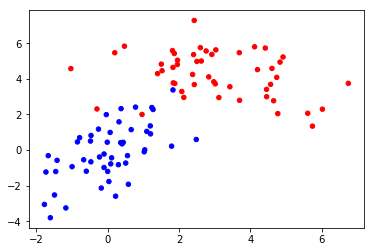

In [25]:
# This code is given 

if False:

    mu1 = [0,0]
    cov1 = np.matrix([[1.5,1.2],[1.2,2.5]])
    mu2 = [3,4]
    cov2 = np.matrix([[3,-.9],[-.9,2]])

    N=50

    d1 = np.random.multivariate_normal(mu1,cov1,N)
    d2 = np.random.multivariate_normal(mu2,cov2,N)

    d = np.concatenate((d1,d2))
    l = np.concatenate((np.zeros((N,1)),np.ones((N,1))))
    perm = np.random.permutation(d.shape[0])
    d = d[perm,:]
    l = l[perm]
    # np.savez("data-2class-nonlin-tmp",d=d,l=l)
    np.savez("data-2class-nonlin",d=d,l=l)
else:
    data = np.load("data-2class-nonlin.npz")
    d = data['d']
    l = data['l']

colours = [ [ 'b', 'r' ][int(x)] for x in np.nditer(l)] 

plt.scatter(d[:,0],d[:,1],20,colours)
plt.show()




# Basis functions

From the plot, it seems that we can do better than simply use a linear classifier. How about using a polynomial function as a discriminant? What about a quadratic function? Or a third-order polynomial?

Such a polynomial function is a function of the type $y = w_0 + w_1 x + w_2 x^2 + w_3 x^3$, *etc.*. Notice how, in the previous equation, y is a non-linear function of x _but a linear function of $\w$_. Optimising the function with respect to $\w$ is still just as easy as last week. In actual fact, we are interested in a function of $x_1$ and $x_2$ rather than only $x$, but the principle is the same: $f(\x,\w)$ is still a linear function of $\w$. 

Here, we implement a Python function that takes in $\x$ and the order of the polynomial, and returns the feature vector $\feat$. For example `feat([x1,x2],2)` returns `[1,x1,x2,x1*x1,x1*x2,x2*x2]`. Try to understand what this is doing. Remember how each extra dimension exponentially increases the complexity of the problem, and notice how the number of features increases exponentially with the order of the polynomial. This is a strong indication that we want to keep the order of the polynomial as low as possible.


[1. 1. 2.]
[[ 1.  3.  4.  9. 12. 16. 27. 36. 48. 64.]
 [ 1.  3.  4.  9. 12. 16. 27. 36. 48. 64.]
 [ 1.  3.  4.  9. 12. 16. 27. 36. 48. 64.]
 [ 1.  3.  4.  9. 12. 16. 27. 36. 48. 64.]
 [ 1.  3.  4.  9. 12. 16. 27. 36. 48. 64.]]
(100, 2)
[1, 3, 6, 10, 15, 21, 28, 36, 45, 55, 66, 78, 91, 105, 120, 136, 153, 171, 190, 210, 231, 253, 276, 300, 325, 351, 378, 406, 435, 465, 496, 528, 561, 595, 630, 666, 703, 741, 780, 820, 861, 903, 946, 990, 1035, 1081, 1128, 1176, 1225, 1275, 1326, 1378, 1431, 1485, 1540, 1596, 1653, 1711, 1770, 1830, 1891, 1953, 2016, 2080, 2145, 2211, 2278, 2346, 2415, 2485, 2556, 2628, 2701, 2775, 2850, 2926, 3003, 3081, 3160, 3240, 3321, 3403, 3486, 3570, 3655, 3741, 3828, 3916, 4005, 4095, 4186, 4278, 4371, 4465, 4560, 4656, 4753, 4851, 4950, 5050]


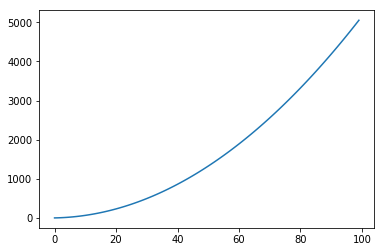

In [4]:
# This code is given

def feat(v, order):
    res = []
    prevStage = [1.]
    prevcode = [ [ 0 ] * len(v) ]               # list of lists; for every number of prevstage, 
    res = prevStage                             # how often every element of v is part of the product
    for o in range(order):                      # for every order
        stage = []
        code = []
        for ps,pc in zip(prevStage,prevcode):   
            for i in range(len(v)):
                c = [ n for n in pc ]
                c[i] += 1
                if c not in code:
                    stage.append(v[i] * ps)
                    code.append(c)
        res.extend(stage)
        prevStage = stage
        prevcode = code
    return np.array(res)

    
print(feat(np.array([1,2]), 1))

M=np.matrix([ feat(np.arange(2)+3.,3) for k in range(5) ])
print (M)
print (d.shape)

dims = [ len(feat([0,0],o)) for o in range(100)]
print(dims)

plt.plot(dims)

## Gradient descent and plotting the probability 

Here is some code for visualising the probability of the class given the input and for performing the gradient descent on the weights.

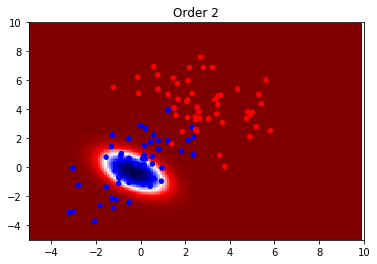

In [6]:
# This code is given

xx,yy = np.mgrid[-5:10:.1,-5:10:.1]

def plotHeat(w):
    order = dims.index(w.size)
    p = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            p[i,j] = sigma(w.dot(feat(np.array([xx[i,j], yy[i,j]]), order)))
    plt.pcolor(xx,yy,p,cmap='seismic')
    plt.xlim([-5,10])
    plt.ylim([-5,10])
    plt.title("Order "+str(order))

def plotData():
    plt.scatter(d[:,0],d[:,1],20,colours)

w = np.array([0,1,1,1,1,1])
plotHeat(w)
plotData()



In [7]:
# This code is given

def errorfun(w, data, labels):
    logprob = 0
    for x,c in zip(data,labels):
        logprob += log1pe(-w.dot(x)) + (1.-c)*w.dot(x)

    return logprob

def optimiseDisc(w, data, labels, eta=1e-3, maxrun=10000):
    newError = errorfun(w,data,labels)
    pastError = newError + 10
    es = []
    n=0
    while pastError-newError > 1e-5 and n<maxrun:
        n+=1
        grad = np.zeros(w.shape)
        for x,c in zip(data,labels):
            grad += (sigma(w.dot(x)) - c) * x
        pw = copy.copy(w)
        w -= eta * grad
        
        pastError = newError
        newError = errorfun(w,data,labels)
        while eta > 0. and pastError - newError < 0: # If the error increases, eta is too large
            eta /= 2                                # halve it, and
            w = pw - eta * grad                      # try again from the original value of the weights
            newError = errorfun(w,data,labels)
        else:                                        # If the error goes down,
            eta *= 1.2                               # try to increase eta a little, to speed up things.
        
        if newError<pastError:
            es.append(newError)
        else:                                        # If we couldn't decrease the error anymore, 
            break                                    # just give up.
 #       print n, pastError, newError, pastError-newError, eta
 
    return w, newError
    


# Generalisation

**Question 1 [5 credits]** Evaluate the error on the training set of gradient descent, with different orders of your feature vector. 

Pay attention to the evolution of the error function during the training; if you notice that the error goes up at times, your step size $\eta$ is too large and you should reduce it. This error should keep diminishing: if it doesn't, you either stopped training too soon, or (for higher-order functions) you got stuck in a local optimum.

[0.]


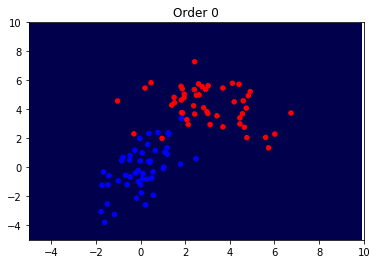

[0. 0. 0.]


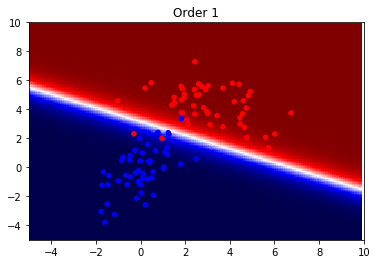

[-6.52205035  0.98590406  2.09001299  0.          0.          0.        ]


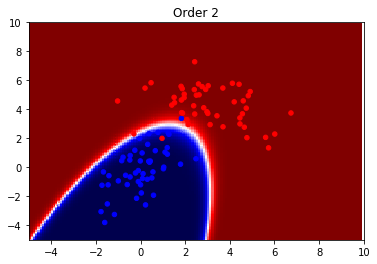

[-7.18182937 -0.89600792  2.5297518   1.08872685 -0.61834631  0.16733216
  0.          0.          0.          0.        ]


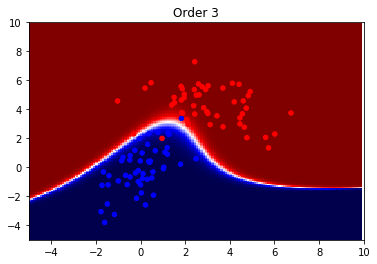

[-7.20622925 -0.92867315  2.54603417  0.98251452 -0.69685084  0.11079406
 -0.04049868  0.31802556 -0.16112029  0.03547866  0.          0.
  0.          0.          0.        ]


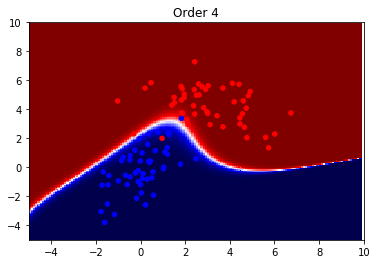

[-7.20669828 -0.928043    2.54635614  0.97921314 -0.69887135  0.10485902
 -0.04397404  0.32310416 -0.17330637  0.01516166 -0.00735586  0.02491563
  0.01973918 -0.02440766  0.01150249  0.          0.          0.
  0.          0.          0.        ]


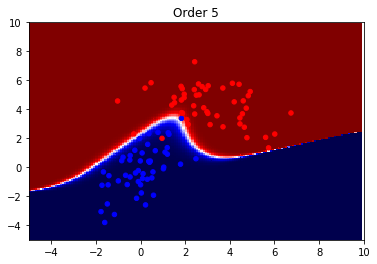

[-7.20638480e+00 -9.27146282e-01  2.54737681e+00  9.78441071e-01
 -6.98386071e-01  1.04291698e-01 -4.56073487e-02  3.24431114e-01
 -1.76151931e-01  7.60023794e-03 -1.27925034e-02  2.90527937e-02
  2.19993384e-02 -3.73841347e-02 -9.27501713e-03 -6.44027168e-03
  1.84435887e-02  1.90265021e-02  9.47964974e-03 -2.00751881e-02
  1.16687812e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


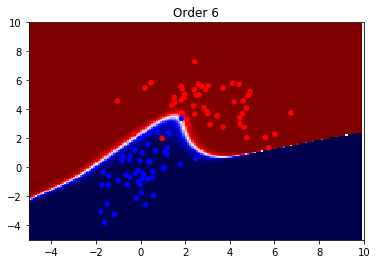

[-7.20634686e+00 -9.27066505e-01  2.54747079e+00  9.78414407e-01
 -6.98318991e-01  1.04314557e-01 -4.56978272e-02  3.24484217e-01
 -1.76277195e-01  7.17193091e-03 -1.31360067e-02  2.91314755e-02
  2.19559557e-02 -3.82556392e-02 -1.10836855e-02 -6.86819624e-03
  1.89962505e-02  1.94506883e-02  9.18634233e-03 -2.25720420e-02
  7.70973699e-03 -6.29789299e-04  2.17095586e-03  2.59559819e-03
  1.91785877e-03  6.63914454e-04 -2.37941161e-03  2.13429017e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


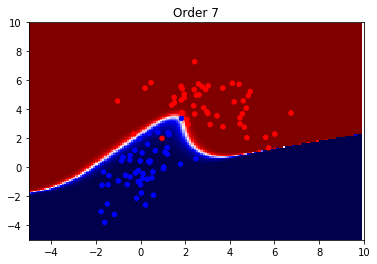

[-7.20634514e+00 -9.27063237e-01  2.54747476e+00  9.78413252e-01
 -6.98316419e-01  1.04315270e-01 -4.57021064e-02  3.24485034e-01
 -1.76283850e-01  7.15092477e-03 -1.31518415e-02  2.91307482e-02
  2.19479240e-02 -3.83009813e-02 -1.11813874e-02 -6.89273573e-03
  1.90076805e-02  1.94513240e-02  9.14600789e-03 -2.27271441e-02
  7.41756142e-03 -6.82142301e-04  2.22914737e-03  2.65867830e-03
  1.92741575e-03  5.63256830e-04 -2.74031673e-03  1.57684235e-03
 -5.35334624e-05  2.08541698e-04  2.74601904e-04  2.53148877e-04
  1.52608406e-04  6.73789269e-06 -2.52596915e-04  3.31259521e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


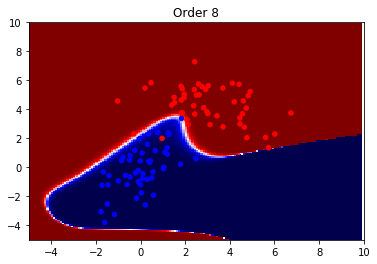

[-7.20634479e+00 -9.27062595e-01  2.54747556e+00  9.78413112e-01
 -6.98315865e-01  1.04315481e-01 -4.57027870e-02  3.24485258e-01
 -1.76285039e-01  7.14679734e-03 -1.31545889e-02  2.91306670e-02
  2.19462559e-02 -3.83101396e-02 -1.12022779e-02 -6.89718859e-03
  1.90096598e-02  1.94507809e-02  9.13629795e-03 -2.27620421e-02
  7.34630930e-03 -6.92643643e-04  2.23904121e-03  2.66837459e-03
  1.92392061e-03  5.30644197e-04 -2.84197060e-03  1.38625075e-03
 -7.07029131e-05  2.43338682e-04  3.19978606e-04  2.87846491e-04
  1.51349203e-04 -6.39946268e-05 -4.70105620e-04 -1.38635287e-05
 -3.18856769e-05  9.99143828e-05  1.45153306e-04  1.57710064e-04
  1.39958315e-04  8.23168400e-05 -2.91115869e-06 -1.26332224e-04
  1.86437802e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]


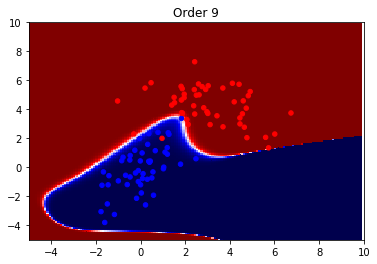

[-7.20634479e+00 -9.27062589e-01  2.54747556e+00  9.78413110e-01
 -6.98315862e-01  1.04315481e-01 -4.57027944e-02  3.24485256e-01
 -1.76285054e-01  7.14675349e-03 -1.31546156e-02  2.91306595e-02
  2.19462299e-02 -3.83102376e-02 -1.12024930e-02 -6.89723406e-03
  1.90096612e-02  1.94507505e-02  9.13617023e-03 -2.27624203e-02
  7.34554421e-03 -6.92749489e-04  2.23909092e-03  2.66839973e-03
  1.92379289e-03  5.30188721e-04 -2.84317159e-03  1.38395418e-03
 -7.08885017e-05  2.43557365e-04  3.20238159e-04  2.87929559e-04
  1.50962392e-04 -6.53025946e-05 -4.73330597e-04 -1.95976140e-05
 -3.22586700e-05  1.00589786e-04  1.46109607e-04  1.58592436e-04
  1.40350117e-04  8.15499549e-05 -5.76372419e-06 -1.33026340e-04
  1.76490250e-04 -2.68963618e-07  1.93765497e-06  2.82144338e-06
  3.22395848e-06  3.14237173e-06  2.30999081e-06  4.50969808e-07
 -2.00219399e-06 -4.22576277e-06  6.33968359e-06  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

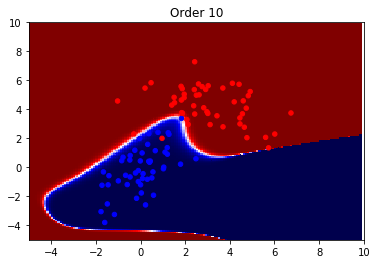

[-7.20634479e+00 -9.27062589e-01  2.54747557e+00  9.78413110e-01
 -6.98315862e-01  1.04315481e-01 -4.57027946e-02  3.24485256e-01
 -1.76285055e-01  7.14675226e-03 -1.31546162e-02  2.91306592e-02
  2.19462291e-02 -3.83102402e-02 -1.12024988e-02 -6.89723514e-03
  1.90096611e-02  1.94507495e-02  9.13616659e-03 -2.27624305e-02
  7.34552311e-03 -6.92752038e-04  2.23909184e-03  2.66839977e-03
  1.92378868e-03  5.30175340e-04 -2.84320559e-03  1.38388747e-03
 -7.08933576e-05  2.43561919e-04  3.20243137e-04  2.87929138e-04
  1.50948166e-04 -6.53445154e-05 -4.73430418e-04 -1.97846684e-05
 -3.22706091e-05  1.00603945e-04  1.46129705e-04  1.58608473e-04
  1.40349378e-04  8.15105805e-05 -5.87676142e-06 -1.33281940e-04
  1.76045123e-04 -2.94903109e-07  1.97658256e-06  2.88220033e-06
  3.29020715e-06  3.19673138e-06  2.32302260e-06  3.73567474e-07
 -2.23727224e-06 -4.72461704e-06  5.63715933e-06 -5.72275983e-08
  9.86460215e-08  1.61988298e-07  1.99740857e-07  2.18532693e-07
  2.05201145e-07  1.38789

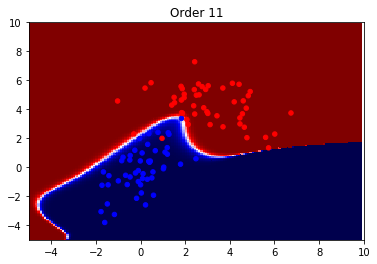

[-7.20634479e+00 -9.27062589e-01  2.54747557e+00  9.78413110e-01
 -6.98315862e-01  1.04315481e-01 -4.57027947e-02  3.24485256e-01
 -1.76285055e-01  7.14675127e-03 -1.31546166e-02  2.91306590e-02
  2.19462285e-02 -3.83102423e-02 -1.12025033e-02 -6.89723591e-03
  1.90096609e-02  1.94507485e-02  9.13616355e-03 -2.27624385e-02
  7.34550682e-03 -6.92753791e-04  2.23909208e-03  2.66839911e-03
  1.92378464e-03  5.30164147e-04 -2.84323255e-03  1.38383425e-03
 -7.08966652e-05  2.43564158e-04  3.20244990e-04  2.87926303e-04
  1.50934059e-04 -6.53812568e-05 -4.73514060e-04 -1.99444019e-05
 -3.22784645e-05  1.00611714e-04  1.46139970e-04  1.58613777e-04
  1.40339311e-04  8.14665205e-05 -5.98668247e-06 -1.33520845e-04
  1.75607475e-04 -3.11239805e-07  1.99908932e-06  2.91601356e-06
  3.32296667e-06  3.21304219e-06  2.29531602e-06  2.52695598e-07
 -2.53046038e-06 -5.33110856e-06  4.60454516e-06 -8.98486458e-08
  1.57792331e-07  2.55839559e-07  3.08791389e-07  3.22661361e-07
  2.67390730e-07  9.16999

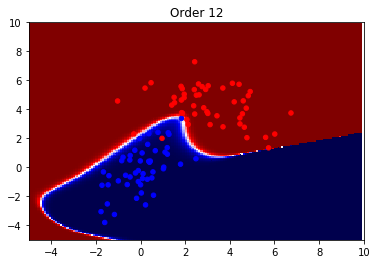

[-7.20634479e+00 -9.27062589e-01  2.54747557e+00  9.78413110e-01
 -6.98315862e-01  1.04315481e-01 -4.57027947e-02  3.24485256e-01
 -1.76285055e-01  7.14675124e-03 -1.31546167e-02  2.91306590e-02
  2.19462284e-02 -3.83102423e-02 -1.12025034e-02 -6.89723593e-03
  1.90096609e-02  1.94507485e-02  9.13616346e-03 -2.27624388e-02
  7.34550625e-03 -6.92753833e-04  2.23909212e-03  2.66839912e-03
  1.92378455e-03  5.30163800e-04 -2.84323347e-03  1.38383231e-03
 -7.08967426e-05  2.43564295e-04  3.20245135e-04  2.87926305e-04
  1.50933675e-04 -6.53824677e-05 -4.73517068e-04 -1.99505283e-05
 -3.22786713e-05  1.00612109e-04  1.46140503e-04  1.58614189e-04
  1.40339220e-04  8.14652045e-05 -5.99054755e-06 -1.33529993e-04
  1.75589364e-04 -3.11743255e-07  2.00012166e-06  2.91756904e-06
  3.32461243e-06  3.21421932e-06  2.29494629e-06  2.48703014e-07
 -2.54177414e-06 -5.35689570e-06  4.55526047e-06 -9.12819434e-08
  1.60283174e-07  2.59903691e-07  3.13700369e-07  3.27687950e-07
  2.71070591e-07  9.10846

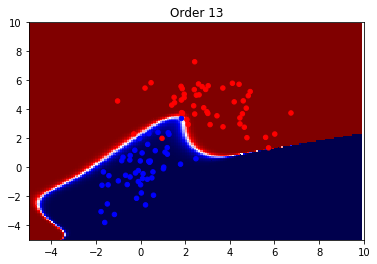

[-7.20634479e+00 -9.27062589e-01  2.54747557e+00  9.78413110e-01
 -6.98315862e-01  1.04315481e-01 -4.57027947e-02  3.24485256e-01
 -1.76285055e-01  7.14675124e-03 -1.31546167e-02  2.91306590e-02
  2.19462284e-02 -3.83102423e-02 -1.12025034e-02 -6.89723593e-03
  1.90096609e-02  1.94507485e-02  9.13616346e-03 -2.27624388e-02
  7.34550621e-03 -6.92753836e-04  2.23909212e-03  2.66839912e-03
  1.92378454e-03  5.30163775e-04 -2.84323354e-03  1.38383218e-03
 -7.08967475e-05  2.43564304e-04  3.20245144e-04  2.87926303e-04
  1.50933645e-04 -6.53825571e-05 -4.73517287e-04 -1.99509772e-05
 -3.22786843e-05  1.00612134e-04  1.46140536e-04  1.58614211e-04
  1.40339205e-04  8.14650988e-05 -5.99084280e-06 -1.33530682e-04
  1.75587983e-04 -3.11774318e-07  2.00018774e-06  2.91766675e-06
  3.32471160e-06  3.21427851e-06  2.29488424e-06  2.48360810e-07
 -2.54268793e-06 -5.35895287e-06  4.55124543e-06 -9.13689095e-08
  1.60443743e-07  2.60161437e-07  3.14004532e-07  3.27981776e-07
  2.71237970e-07  9.08890

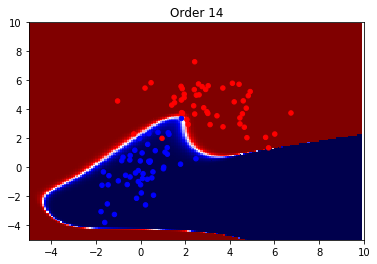

[-7.20634479e+00 -9.27062589e-01  2.54747557e+00  9.78413110e-01
 -6.98315862e-01  1.04315481e-01 -4.57027947e-02  3.24485256e-01
 -1.76285055e-01  7.14675124e-03 -1.31546167e-02  2.91306590e-02
  2.19462284e-02 -3.83102423e-02 -1.12025034e-02 -6.89723593e-03
  1.90096609e-02  1.94507485e-02  9.13616346e-03 -2.27624388e-02
  7.34550620e-03 -6.92753836e-04  2.23909212e-03  2.66839912e-03
  1.92378454e-03  5.30163769e-04 -2.84323355e-03  1.38383214e-03
 -7.08967484e-05  2.43564306e-04  3.20245146e-04  2.87926303e-04
  1.50933639e-04 -6.53825779e-05 -4.73517338e-04 -1.99510844e-05
 -3.22786868e-05  1.00612140e-04  1.46140543e-04  1.58614217e-04
  1.40339202e-04  8.14650738e-05 -5.99091338e-06 -1.33530848e-04
  1.75587643e-04 -3.11780563e-07  2.00020311e-06  2.91768924e-06
  3.32473434e-06  3.21429166e-06  2.29486813e-06  2.48276197e-07
 -2.54291485e-06 -5.35946913e-06  4.55021455e-06 -9.13872594e-08
  1.60480794e-07  2.60220413e-07  3.14073822e-07  3.28047676e-07
  2.71271749e-07  9.08309

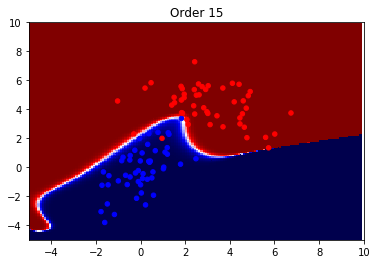

[-7.20634479e+00 -9.27062589e-01  2.54747557e+00  9.78413110e-01
 -6.98315862e-01  1.04315481e-01 -4.57027947e-02  3.24485256e-01
 -1.76285055e-01  7.14675124e-03 -1.31546167e-02  2.91306590e-02
  2.19462284e-02 -3.83102423e-02 -1.12025034e-02 -6.89723593e-03
  1.90096609e-02  1.94507485e-02  9.13616346e-03 -2.27624388e-02
  7.34550620e-03 -6.92753836e-04  2.23909212e-03  2.66839912e-03
  1.92378454e-03  5.30163769e-04 -2.84323356e-03  1.38383214e-03
 -7.08967485e-05  2.43564306e-04  3.20245146e-04  2.87926303e-04
  1.50933638e-04 -6.53825797e-05 -4.73517343e-04 -1.99510943e-05
 -3.22786870e-05  1.00612140e-04  1.46140544e-04  1.58614217e-04
  1.40339202e-04  8.14650717e-05 -5.99091976e-06 -1.33530864e-04
  1.75587611e-04 -3.11781027e-07  2.00020462e-06  2.91769145e-06
  3.32473662e-06  3.21429314e-06  2.29486695e-06  2.48268626e-07
 -2.54293602e-06 -5.35951849e-06  4.55011360e-06 -9.13887232e-08
  1.60484395e-07  2.60226100e-07  3.14080573e-07  3.28054252e-07
  2.71275456e-07  9.08260

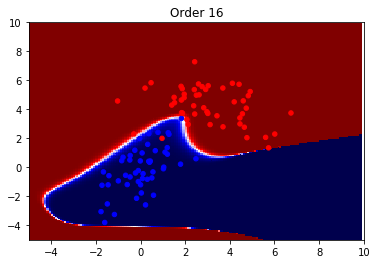

[-7.20634479e+00 -9.27062589e-01  2.54747557e+00  9.78413110e-01
 -6.98315862e-01  1.04315481e-01 -4.57027947e-02  3.24485256e-01
 -1.76285055e-01  7.14675124e-03 -1.31546167e-02  2.91306590e-02
  2.19462284e-02 -3.83102423e-02 -1.12025034e-02 -6.89723593e-03
  1.90096609e-02  1.94507485e-02  9.13616346e-03 -2.27624388e-02
  7.34550620e-03 -6.92753836e-04  2.23909212e-03  2.66839912e-03
  1.92378454e-03  5.30163769e-04 -2.84323356e-03  1.38383214e-03
 -7.08967485e-05  2.43564306e-04  3.20245146e-04  2.87926303e-04
  1.50933638e-04 -6.53825800e-05 -4.73517344e-04 -1.99510956e-05
 -3.22786870e-05  1.00612140e-04  1.46140544e-04  1.58614217e-04
  1.40339202e-04  8.14650714e-05 -5.99092056e-06 -1.33530866e-04
  1.75587607e-04 -3.11781074e-07  2.00020483e-06  2.91769175e-06
  3.32473695e-06  3.21429337e-06  2.29486685e-06  2.48267703e-07
 -2.54293873e-06 -5.35952497e-06  4.55010007e-06 -9.13888843e-08
  1.60484886e-07  2.60226870e-07  3.14081498e-07  3.28055178e-07
  2.71276035e-07  9.08255

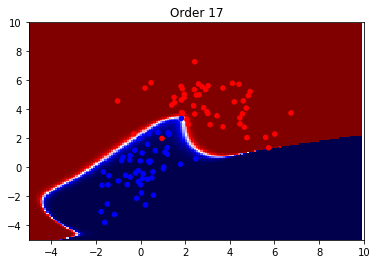

[-7.20634479e+00 -9.27062589e-01  2.54747557e+00  9.78413110e-01
 -6.98315862e-01  1.04315481e-01 -4.57027947e-02  3.24485256e-01
 -1.76285055e-01  7.14675124e-03 -1.31546167e-02  2.91306590e-02
  2.19462284e-02 -3.83102423e-02 -1.12025034e-02 -6.89723593e-03
  1.90096609e-02  1.94507485e-02  9.13616346e-03 -2.27624388e-02
  7.34550620e-03 -6.92753836e-04  2.23909212e-03  2.66839912e-03
  1.92378454e-03  5.30163769e-04 -2.84323356e-03  1.38383214e-03
 -7.08967485e-05  2.43564306e-04  3.20245146e-04  2.87926303e-04
  1.50933638e-04 -6.53825800e-05 -4.73517344e-04 -1.99510957e-05
 -3.22786870e-05  1.00612140e-04  1.46140544e-04  1.58614217e-04
  1.40339202e-04  8.14650714e-05 -5.99092060e-06 -1.33530866e-04
  1.75587606e-04 -3.11781075e-07  2.00020484e-06  2.91769176e-06
  3.32473696e-06  3.21429338e-06  2.29486685e-06  2.48267665e-07
 -2.54293885e-06 -5.35952525e-06  4.55009947e-06 -9.13888903e-08
  1.60484908e-07  2.60226904e-07  3.14081540e-07  3.28055220e-07
  2.71276064e-07  9.08254

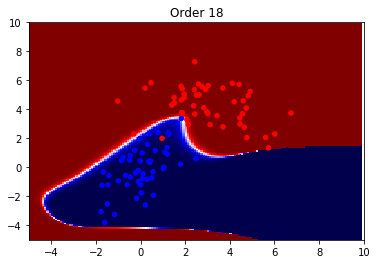

[-7.20634479e+00 -9.27062589e-01  2.54747557e+00  9.78413110e-01
 -6.98315862e-01  1.04315481e-01 -4.57027947e-02  3.24485256e-01
 -1.76285055e-01  7.14675124e-03 -1.31546167e-02  2.91306590e-02
  2.19462284e-02 -3.83102423e-02 -1.12025034e-02 -6.89723593e-03
  1.90096609e-02  1.94507485e-02  9.13616346e-03 -2.27624388e-02
  7.34550620e-03 -6.92753836e-04  2.23909212e-03  2.66839912e-03
  1.92378454e-03  5.30163769e-04 -2.84323356e-03  1.38383214e-03
 -7.08967485e-05  2.43564306e-04  3.20245146e-04  2.87926303e-04
  1.50933638e-04 -6.53825800e-05 -4.73517344e-04 -1.99510957e-05
 -3.22786870e-05  1.00612140e-04  1.46140544e-04  1.58614217e-04
  1.40339202e-04  8.14650714e-05 -5.99092060e-06 -1.33530866e-04
  1.75587606e-04 -3.11781076e-07  2.00020484e-06  2.91769176e-06
  3.32473696e-06  3.21429338e-06  2.29486685e-06  2.48267663e-07
 -2.54293885e-06 -5.35952526e-06  4.55009944e-06 -9.13888906e-08
  1.60484909e-07  2.60226906e-07  3.14081541e-07  3.28055222e-07
  2.71276065e-07  9.08254

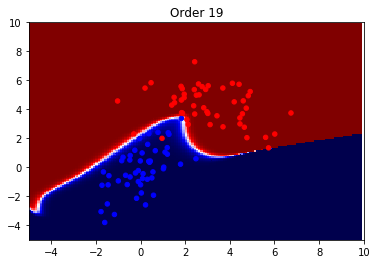

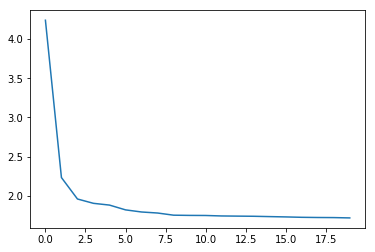

The error keeps diminishing as expected when we increase the order of our polynomial.
The first orders show a great improvement as the error decreases steeply, then after order 2/3, it decreases more slowly.


In [27]:
#ANSQ1
order_l = range(20)
error_l = []
w_l = []
draw_it = True
w = np.zeros(0)

def get_dims(n):
    if n < 0: return 0
    return dims[n]

for order in order_l:
    w_0 = np.concatenate((w, np.zeros(get_dims(order)-get_dims(order-1))))
    print(w_0)
    w, error = optimiseDisc(w_0, np.array([feat(x, order) for x in d]), l)
    if draw_it:
        plotHeat(w)
        plotData()
        plt.show()
    error_l += [error]
    w_l += [w]
    
plt.plot(np.log(error_l))
plt.show()
print("""The error keeps diminishing as expected when we increase the order of our polynomial.
The first orders show a great improvement as the error decreases steeply, then after order 2/3, it decreases more slowly.""")


#/ANSQ1

# Generalisation

Evaluate the error on the training set of gradient descent, with different orders of your feature vector. Pay attention to the evolution of the error function during the training; if you notice that the error goes up at times, your step size $\eta$ is too large and you should reduce it. This error should keep diminishing: if it doesn't, you either stopped training too soon, or (for higher-order functions) you got stuck in a local optimum.

Local optima are a problem for complex models. Sometimes, a complex model really is warranted, but finding optimal parameter values for it is difficult. In general, one solution is to initialise the parameters at random, run multiple optimisation runs, and keep the run with the best results. 

**Question 2 [10 credits]**: In this case, where there is a clear relationship between the parameters of the models of increasing complexity, can you think of a way to ensure that increasing the complexity of the model is guaranteed to reduce the training error (and so that, even if you get stuck in a local optimum, you're at least certain that it is an optimum that's better than the best model you've found so far? Does this strategy have disadvantages?


%%ANSQ2
What we do to be sure to reduce the error when increasing the order is using the final discriminant from the previous order.
Indeed, if we start optimising order N using the previous solution, we are sure to converge to a local optimum at least better than the previous one.

Thus to compute the initial discriminant for order N w_0_N, we can concatenate the final discriminant of order N-1 w_f_{N-1} with zeros.

We need to increase the size of w when increasing the order because the size of the feature vector grows when the order grows. And we only concatenate zeros at the end of w_f_{N-1} because we want to keep the previous solution.

This strategy has some advantages: we are certain the error will decrease or stay the same when we increase the order, the computation time is decreased compared to always start with a random discriminant because we know that we are near a local optimum and we have little to learn to reach the new local optimum.

But this strategy has disadvantages: to compute the solution for order N, we need to compute the solution for order N-1, and for all previous orders. Moreover the solution at order N will always be relatively close to the solution at order N-1, thus if the previous iteration converged to a local optimum which is not the best, we will stay near this previous solution and converge again to a "bad" local optimum again.
For example, the solution for order 4 sticks to blue data a lot more than order 3. And all the following orders also stick to the blue data as order 4 did.

%%/ANSQ2


**Question 3 [10 credits]**: Divide your data into a training and test set. Plot the evolution of the error on both the train and the test set in function of the order of the polynomial.


[0.]


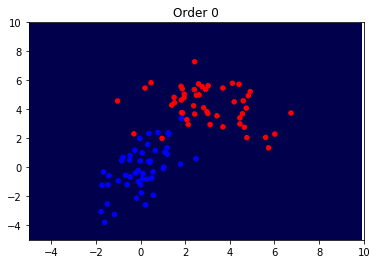

[-0.38767725  0.          0.        ]


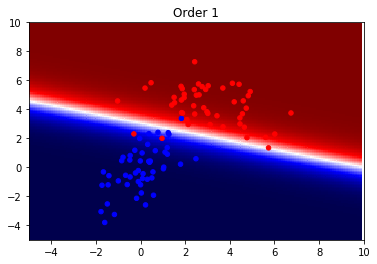

[-4.98103904  0.50221555  1.64509815  0.          0.          0.        ]


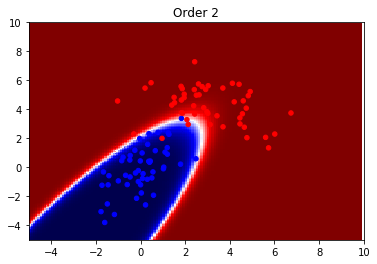

[-5.63558126 -0.36608575  1.63509265  1.14207684 -1.25499166  0.43552041
  0.          0.          0.          0.        ]


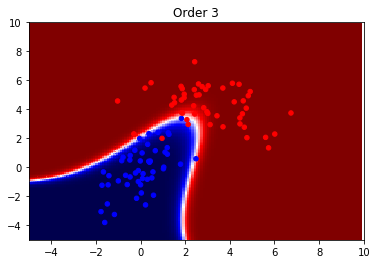

[-5.64966535 -0.39006327  1.65414013  1.02355845 -1.35986993  0.36682906
  0.09852381  0.09268648 -0.09724699  0.04749667  0.          0.
  0.          0.          0.        ]


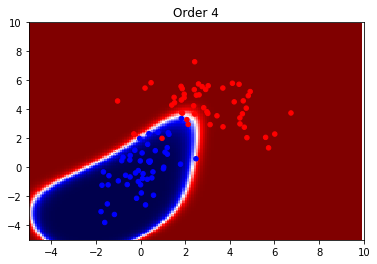

[-5.64796741e+00 -3.89784644e-01  1.66108805e+00  1.01050792e+00
 -1.36833181e+00  3.63655135e-01  8.96075953e-02  8.18081692e-02
 -1.27463206e-01  1.80314873e-02  2.17074267e-03  2.39103036e-02
  1.77609382e-02 -1.80280534e-02  1.34740947e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


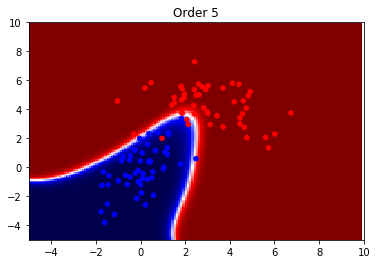

[-5.64780570e+00 -3.89681086e-01  1.66156636e+00  1.00995380e+00
 -1.36860135e+00  3.63750157e-01  8.89412343e-02  8.09945177e-02
 -1.29124130e-01  1.62969023e-02  1.00477816e-03  2.31679302e-02
  1.59886447e-02 -2.25489411e-02  7.69334063e-03  1.15618741e-03
  2.38066756e-03  2.43281249e-03  1.67622261e-03 -1.76586707e-03
  2.19579212e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


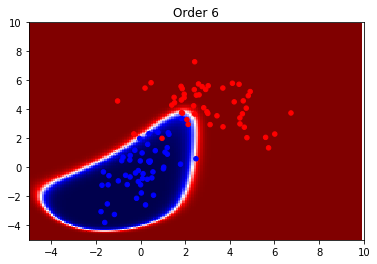

[-5.64775335e+00 -3.89636920e-01  1.66171161e+00  1.00986956e+00
 -1.36860229e+00  3.63882125e-01  8.88122421e-02  8.08616916e-02
 -1.29366998e-01  1.61599008e-02  6.76326677e-04  2.29000406e-02
  1.55051940e-02 -2.35778222e-02  6.40394744e-03  9.33908733e-04
  2.21701294e-03  2.02093455e-03  7.16754832e-04 -4.10217650e-03
 -7.87115109e-04  6.52027132e-05  7.65254644e-04  9.67450992e-04
  9.95173760e-04  7.81720367e-04 -6.19979549e-04  1.07923041e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


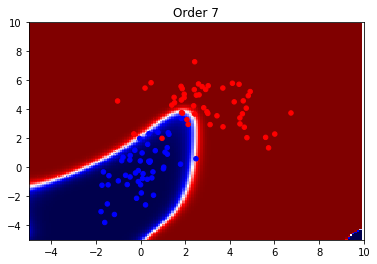

[-5.64775066e+00 -3.89634446e-01  1.66171894e+00  1.00986695e+00
 -1.36860070e+00  3.63890941e-01  8.88075323e-02  8.08576558e-02
 -1.29373770e-01  1.61612081e-02  6.61840580e-04  2.28880718e-02
  1.54851247e-02 -2.36184120e-02  6.35651302e-03  9.17422407e-04
  2.19971043e-03  1.98903221e-03  6.55681200e-04 -4.23133686e-03
 -9.65696774e-04  4.06063289e-05  7.55048979e-04  9.43696495e-04
  9.37099868e-04  6.53908570e-04 -9.18213223e-04  6.23875983e-04
  1.38568344e-05  5.49488261e-05  7.62050735e-05  9.43188143e-05
  1.03886833e-04  9.59515431e-05 -2.90254570e-05  1.39484956e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


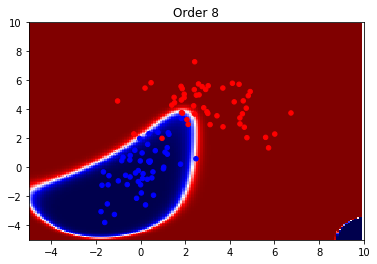

[-5.64775057e+00 -3.89634358e-01  1.66171919e+00  1.00986687e+00
 -1.36860063e+00  3.63891268e-01  8.88073747e-02  8.08575237e-02
 -1.29373984e-01  1.61612865e-02  6.61331230e-04  2.28876326e-02
  1.54844026e-02 -2.36198309e-02  6.35486976e-03  9.16744664e-04
  2.19892840e-03  1.98764220e-03  6.53117467e-04 -4.23651890e-03
 -9.73146803e-04  3.93748781e-05  7.54039360e-04  9.41824658e-04
  9.33401798e-04  6.46728182e-04 -9.33096464e-04  6.00155644e-04
  1.30750634e-05  5.47537885e-05  7.54263482e-05  9.19545473e-05
  9.80563176e-05  8.31566736e-05 -5.81950998e-05  9.29610805e-05
  3.37041296e-07  3.71251998e-06  5.62147977e-06  7.69457272e-06
  9.92330675e-06  1.16357611e-05  1.18861967e-05  2.44490967e-06
  1.16723844e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]


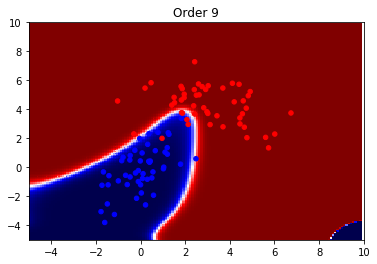

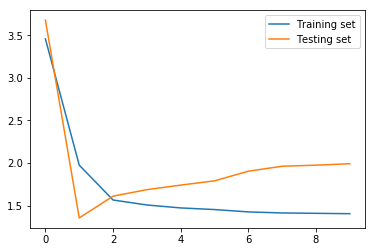

In [28]:
#ANSQ3
import random

def divide_set(data, labels, prop):
    d_training = []
    l_training = []

    d_testing = []
    l_testing = []
    for x,c in zip(data, labels):
        rnd = random.random()
        if rnd < prop:
            d_training += [x]
            l_training += [c]
        else:
            d_testing += [x]
            l_testing += [c]
            
    return np.array(d_training), np.array(l_training), np.array(d_testing), np.array(l_testing)

prop_learning = 0.5
d_training, l_training, d_testing, l_testing = divide_set(d, l, prop_learning)


order_l = range(10)
error_training_l = []
error_testing_l = []
w_l = []
draw_it = True
w = np.zeros(0)

for order in order_l:
    w_0 = np.concatenate((w, np.zeros(get_dims(order)-get_dims(order-1))))
    print(w_0)
    w, error = optimiseDisc(w_0, np.array([feat(x, order) for x in d_training]), l_training)
    if draw_it:
        plotHeat(w)
        plotData()
        plt.show()
    error_training_l += [error]
    error_testing_l +=[errorfun(w, np.array([feat(x, order) for x in d_testing]), l_testing)]
    w_l += [w]

plt.plot(np.log(error_training_l))
plt.plot(np.log(error_testing_l))
plt.legend(["Training set", "Testing set"])
plt.show()
#/ANSQ3


**Question 4 [10 credits]**: Now perform 5-fold cross-validation on the data set and create the same plot as in the previous question. Doing cross-validation gives you a more accurate and stable estimate of the error of your model on unseen data, but it also gives you an idea of the spread of this error and therefore a (optimistic) idea of the upper and lower bounds on your error. Use error bars to show the standard deviation on your cross-validation error.



[55.22656303840085, 55.42677194089645, 55.451774444795646, 55.42677194089642, 55.22656303840086]
[55.35168888067805, 7.245040092618052, 5.362726473477666, 4.9177613789384615, 4.85072090221894, 4.6176450287568365, 4.482959726816061, 4.457745511777556, 4.318389374900025, 4.248251190489536]
[0.1025719306822372, 1.5778837906469594, 2.2583485687952547, 2.460862151394257, 2.433818200692839, 2.306702980809366, 2.2372305783945645, 2.2247190818087588, 2.1625071518293093, 2.126658311958353]


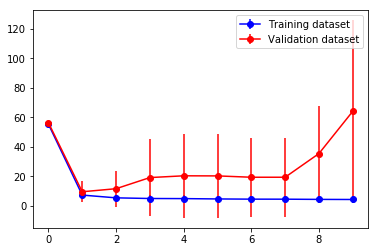

In [36]:
#ANSQ4
def kcv_split(data, labels, n):
    data  = copy.copy(data)
    labels = copy.copy(labels)
    
    z = list(zip(data, labels))
    random.shuffle(z)
    data, labels = zip(*z)

    sets_data = []
    sets_labels = []
    for i in range(n):
        sets_data += [np.array(data[int(i*len(data)/n):int((i+1)*len(data)/n)])]
        sets_labels += [np.array(labels[int(i*len(data)/n):int((i+1)*len(data)/n)])]
    return sets_data, sets_labels

data_sets, labels_sets = kcv_split(d, l, 5)

order_l = list(range(10))
error_training_ll = [[] for _ in order_l]
error_validation_ll = [[] for _ in order_l]
w_l = []
draw_it = True
w = np.zeros(0)

for i in range(5):
    data_validation = np.array(data_sets[i])
    labels_validation = np.array(labels_sets[i])
    
    data_training = []
    labels_training = []
    for j in range(5):
        if i==j: continue            
        data_training += [*data_sets[j]]
        labels_training += [*labels_sets[j]]
    data_training = np.array(data_training)
    labels_training = np.array(labels_training)
    
    w = np.zeros(0)
    
    for order in order_l:
        w_0 = np.concatenate((w, np.zeros(get_dims(order)-get_dims(order-1))))

        w, error = optimiseDisc(w_0, np.array([feat(x, order) for x in data_training]), labels_training)

        error_training_ll[order] += [*error]
        error_validation_ll[order] += [*errorfun(w, np.array([feat(x, order) for x in data_validation]), labels_validation)]
        w_l += [w]
    

mean_error_training_l = [np.mean(error_training_ll[o]) for o in order_l]
mean_error_validation_l = [np.mean(error_validation_ll[o]) for o in order_l]

std_error_training_l = [np.std(error_training_ll[o]) for o in order_l]
std_error_validation_l = [np.std(error_validation_ll[o]) for o in order_l]

print(error_training_ll[0])
print(mean_error_training_l)
print(std_error_training_l)

plt.errorbar(order_l, [i for i in mean_error_training_l], yerr=std_error_training_l, fmt='-ob')
plt.errorbar(order_l, [i*4 for i in mean_error_validation_l], yerr=[i*4 for i in std_error_validation_l], fmt='-or')

plt.legend(['Training dataset', 'Validation dataset'])
#/ANSQ4
print("""""")

**Question 5 [5 credits]**: What order should the polynomial be, do you think? Why do you think that?

%%ANSQ5

%%/ANSQ5